## Sign Language Digits Dataset
### Turkey Ankara Ayrancı Anadolu High School's Sign Language Digits Dataset
https://www.kaggle.com/ardamavi/sign-language-digits-dataset

### Context
Sign languages (also known as signed languages) are languages that use manual communication to convey meaning. This can include simultaneously employing hand gestures, movement, orientation of the fingers, arms or body, and facial expressions to convey a speaker's ideas.

### Details of datasets:
* Image size: 64x64
* Color space: Grayscale
* File format: npy
* Number of classes: 10 (Digits: 0-9)
* Number of participant students: 218
* Number of samples per student: 10

In [ ]:
import json
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
X = np.load('X.npy')
y = np.load('Y.npy')

In [ ]:
# Делаю данные 4-мерными
X = X[:, :, :, np.newaxis]

In [ ]:
X.shape

(2062, 64, 64, 1)

In [ ]:
y.shape

(2062, 10)

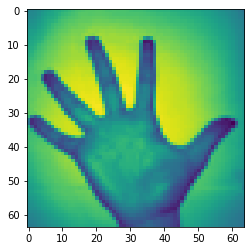

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
plt.imshow(X[2000,:,:,0])
plt.show()
print(y[2000])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
Flatten the images.
X_train_flatten = X_train.reshape((-1, X_train.shape[1] * X_train.shape[2]))
X_test_flatten = X_test.reshape((-1, X_test.shape[1] * X_test.shape[2]))

In [ ]:
X_train_flatten.shape

(1649, 4096)

In [ ]:
n = 10
n_epoches = 500

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=10)

Baseline model. 4 полносвязных слоя.

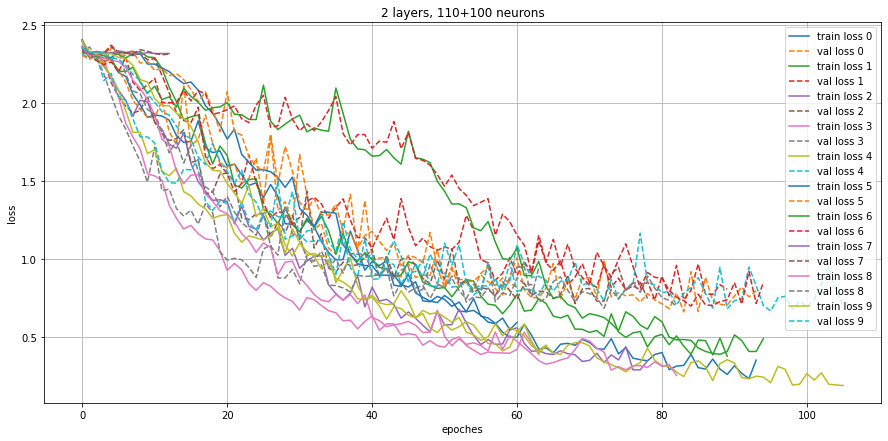

CPU times: user 1min 46s, sys: 16.3 s, total: 2min 2s
Wall time: 2min 6s


In [ ]:
%%time
test_callbacks1 = []
plt.figure(figsize=(15,7))

for i in range(n):
    # Create a model
    model1 = Sequential([
                         Dense(128, activation='relu', input_shape=(4096,)),
                         Dense(110, activation='tanh'), 
                         Dense(100, activation='tanh'), 
                         Dense(10, activation='softmax')
                         ])

    # Compile a model
        model1.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    # Train the model.
    train_h =  model1.fit(X_train_flatten[:,:],
                        y_train[:,:],
                        epochs=n_epoches,
                        batch_size=64, 
                        validation_data=(X_test_flatten, y_test),
                        callbacks=[callback],
                        verbose=0)

    plt.plot(train_h.history['loss'], '-', label = f'train loss {i}')
    plt.plot(train_h.history['val_loss'], '--', label = f'val loss {i}')

    test_callbacks1.append(train_h.history)

plt.xlabel('epoches')
plt.ylabel('loss')
plt.legend()
plt.grid('On')
plt.title('2 layers, 110+100 neurons')
plt.show()

In [ ]:
a = 0
for i in range(n):
    a += test_callbacks1[i]['val_accuracy'][-1]
print(a / n)

0.7024213038384914


Callback останавливал обучение модели. Только  одна попытка длились более 100 эпох. В одном из экспериментов, которые не представленны в данном ноутбуке, обучал модель без callback на 500 эпохах. Максимальный результат получился немногим меньше 0.9.

## Создам 4 варианта сверточных нейронных сетей
### 3 блока Cov2D+MaxPeeling2D

In [ ]:
input0 = Input(shape=X_train.shape[1:])

x0 = Conv2D(64, (3, 3), padding='same', activation='relu')(input0)
x1 = MaxPooling2D(pool_size=(2, 2))(x0)

x2 = Conv2D(128, (3, 3), padding='same', activation='relu')(x1)
x3 = MaxPooling2D(pool_size=(2, 2))(x2)
x4 = Dropout(0.1)(x3)

x5 = Conv2D(256, (3, 3), padding='same', activation='relu')(x4)
x6 = MaxPooling2D(pool_size=(2, 2))(x5)
x7 = Dropout(0.1)(x6)

x8 = Flatten()(x7)
x9 = Dense(512, activation='relu')(x8)
x10 = Dense(512, activation='relu')(x9)
x11 = Dropout(0.5)(x10)

output0 = Dense(y_train.shape[1], activation='softmax')(x11)

В изначальном варианте в данной модели я использовал архитектуру сети AlexNET. Но с 3 слоями Conv2D в 3-м блоке модель плохо обучалась, поэтому оставил 1 слой конволюции.

In [ ]:
%%time
result0 = []
for _ in range(n):
    model0 = Model(inputs=input0, outputs=output0)

    model0.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    
    hh0 = model0.fit(X_train,
                     y_train,
                     epochs=n_epoches,
                     batch_size=64, 
                     validation_data=(X_test, y_test),
                     callbacks=[callback],
                     verbose=0)
    
    result0.append({
        'train_loss': hh0.history['loss'],
        'valid_loss': hh0.history['val_loss'],
        'train_accuracy': hh0.history['accuracy'],
        'valid_accuracy': hh0.history['val_accuracy']
    })

CPU times: user 1min 10s, sys: 7.44 s, total: 1min 17s
Wall time: 3min 54s


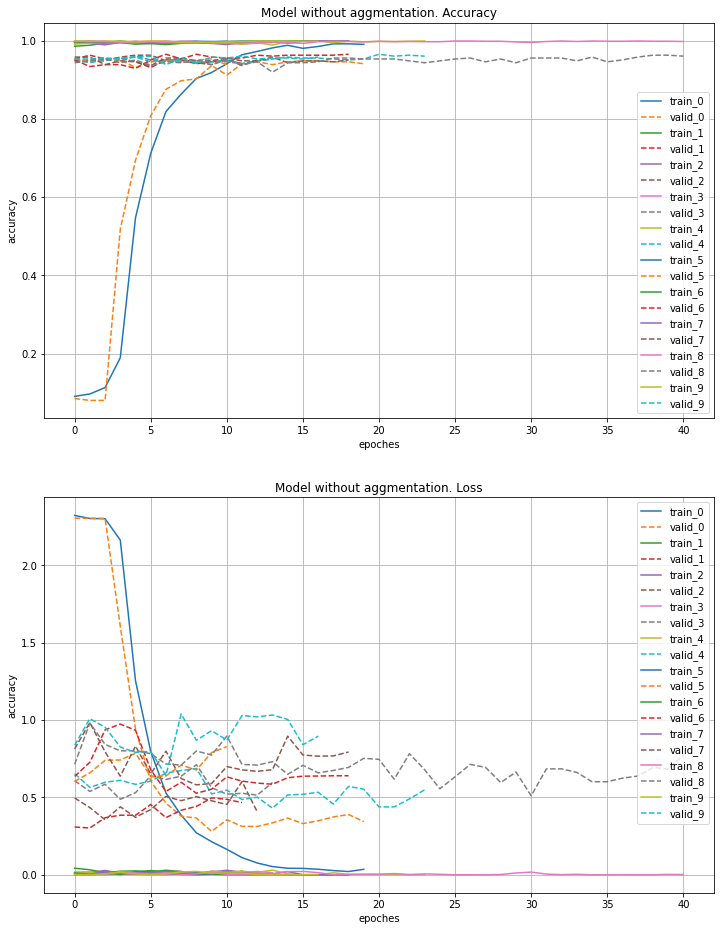

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(2, 1, 1)
for i in range(n):
    plt.plot(result0[i]['train_accuracy'], '-', label=f'train_{i}')
    plt.plot(result0[i]['valid_accuracy'], '--', label=f'valid_{i}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model without aggmentation. Accuracy')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
for j in range(10):
    plt.plot(result0[j]['train_loss'], '-', label=f'train_{j}')
    plt.plot(result0[j]['valid_loss'], '--', label=f'valid_{j}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model without aggmentation. Loss')
plt.grid()
plt.legend()

plt.show()

In [ ]:
model0.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 256)       295

### 3 блока Cov2D+MaxPeeling2D с аугментацию изображений

In [ ]:
datagen = ImageDataGenerator(
          featurewise_center=False,
          samplewise_center=False,
          featurewise_std_normalization=False,
          samplewise_std_normalization=False,
          zca_whitening=False, 
          zca_epsilon=1e-06, 
          rotation_range=5, 
          width_shift_range=0.1,
          height_shift_range=0.1,
          shear_range=0., 
          zoom_range=0., 
          channel_shift_range=0.,
          fill_mode='nearest',
          cval=0.,
          horizontal_flip=True,
          vertical_flip=False,
          rescale=None,
          preprocessing_function=None,
          data_format=None,
          validation_split=0.0)

In [ ]:
datagen.fit(X_train)

In [ ]:
%%time
result1 = []
for _ in range(n):
    model1 = Model(inputs=input0, outputs=output0)

    model1.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    
    hh1 = model1.fit(datagen.flow(X_train, y_train, batch_size=64),
                     validation_data=datagen.flow(X_test, y_test),
                     epochs=n_epoches, workers=10, 
                     callbacks=[callback], verbose=0)
    
    result1.append({
        'train_loss': hh1.history['loss'],
        'valid_loss': hh1.history['val_loss'],
        'train_accuracy': hh1.history['accuracy'],
        'valid_accuracy': hh1.history['val_accuracy']
    })

CPU times: user 9min 56s, sys: 1min 16s, total: 11min 12s
Wall time: 7min 52s


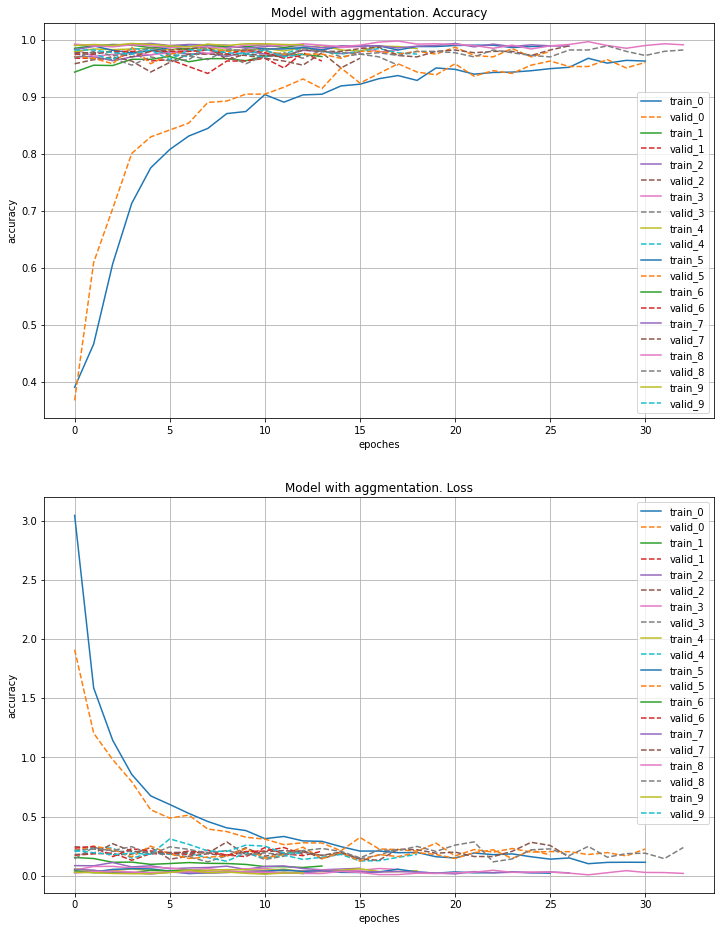

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(2, 1, 1)
for i in range(n):
    plt.plot(result1[i]['train_accuracy'], '-', label=f'train_{i}')
    plt.plot(result1[i]['valid_accuracy'], '--', label=f'valid_{i}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model with aggmentation. Accuracy')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
for j in range(10):
    plt.plot(result1[j]['train_loss'], '-', label=f'train_{j}')
    plt.plot(result1[j]['valid_loss'], '--', label=f'valid_{j}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model with aggmentation. Loss')
plt.grid()
plt.legend()

plt.show()

In [ ]:
print(f"Model0 test accuracy: {np.array([res_['valid_accuracy'][-1] for res_ in result0]).mean()}")
print(f"Model0 test loss: {np.array([res_['valid_loss'][-1] for res_ in result0]).mean()}", end='\n\n')

print(f"Model1 test accuracy: {np.array([res_['valid_accuracy'][-1] for res_ in result1]).mean()}")
print(f"Model1 test loss: {np.array([res_['valid_loss'][-1] for res_ in result1]).mean()}")

Model0 test accuracy: 0.9527845025062561
Model0 test loss: 0.6300362855195999

Model1 test accuracy: 0.9728813588619232
Model1 test loss: 0.19488325119018554


#### Делаю подбор оптимизатора и лосса модели с аугментацией

In [ ]:
losses = ['categorical_crossentropy', 'categorical_hinge']
optimizers = ['Adam', 'Nadam', 'RMSprop', 'Adagrad', 'Adadelta', 'Adamax', 'SGD']

In [ ]:
%%time
result_list0 = []
for loss, optimizer in product(losses, optimizers):
    model_ = Model(inputs=input0, outputs=output0)

    model_.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    hh_ = model_.fit(datagen.flow(X_train, y_train, batch_size=64),
                     validation_data=datagen.flow(X_test, y_test),
                     epochs=n_epoches, workers=10, 
                     callbacks=[callback], verbose=0)
    
    result_list0.append({
        'loss': loss,
        'optimizer': optimizer,
        'train_loss': hh_.history['loss'],
        'valid_loss': hh_.history['val_loss'],
        'train_accuracy': hh_.history['accuracy'],
        'valid_accuracy': hh_.history['val_accuracy']
    })

CPU times: user 11min 45s, sys: 1min 25s, total: 13min 10s
Wall time: 9min 12s


In [ ]:
with open('grid_result0.json', 'w') as f:
    json.dump(result_list0, f, indent=4)

### 3 блока Cov2D+AveragePooling2D

In [ ]:
input1 = Input(shape=X_train.shape[1:])

x20 = Conv2D(64, (3, 3), padding='same', activation='relu')(input1)
x21 = AveragePooling2D(pool_size=(2, 2))(x20)

x22 = Conv2D(128, (3, 3), padding='same', activation='relu')(x21)
x23 = AveragePooling2D(pool_size=(2, 2))(x22)
x24 = Dropout(0.1)(x23)

x25 = Conv2D(256, (3, 3), padding='same', activation='relu')(x24)
x26 = AveragePooling2D(pool_size=(2, 2))(x25)
x27 = Dropout(0.1)(x26)

x28 = Flatten()(x27)
x29 = Dense(512, activation='relu')(x28)
x30 = Dense(512, activation='relu')(x29)
x31 = Dropout(0.5)(x30)

output1 = Dense(y_train.shape[1], activation='softmax')(x31)

In [ ]:
%%time
result10 = []
for _ in range(n):
    model10 = Model(inputs=input1, outputs=output1)

    model10.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    
    hh10 = model10.fit(X_train,
                      y_train,
                      epochs=n_epoches,
                      batch_size=64, 
                      validation_data=(X_test, y_test),
                      callbacks=[callback],
                      verbose=0)
    
    result10.append({
        'train_loss': hh10.history['loss'],
        'valid_loss': hh10.history['val_loss'],
        'train_accuracy': hh10.history['accuracy'],
        'valid_accuracy': hh10.history['val_accuracy']
    })

CPU times: user 1min 24s, sys: 12.9 s, total: 1min 37s
Wall time: 6min 18s


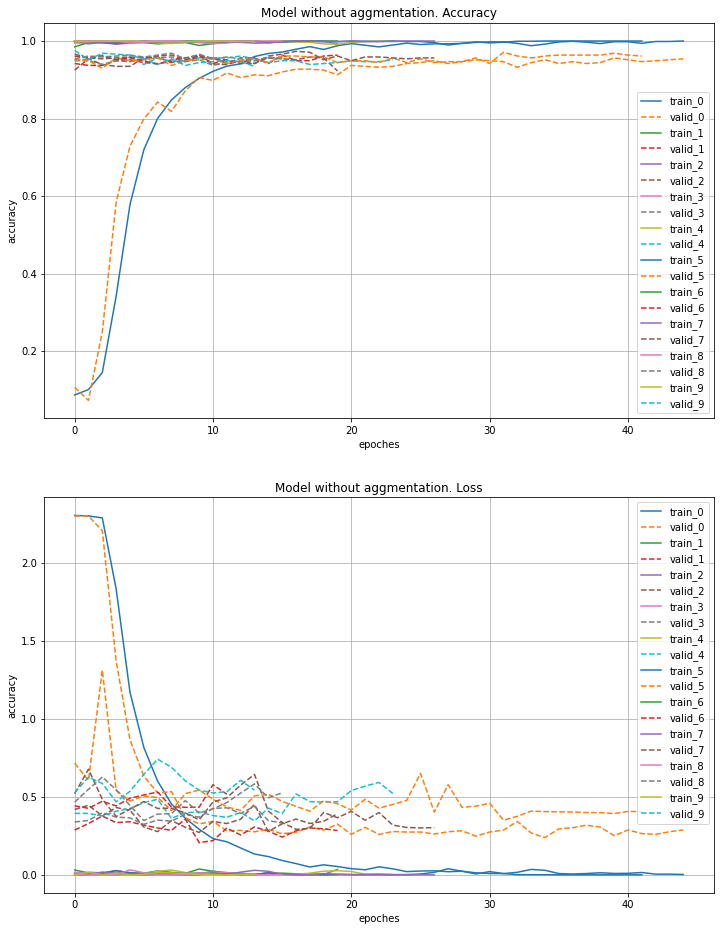

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(2, 1, 1)
for i in range(n):
    plt.plot(result10[i]['train_accuracy'], '-', label=f'train_{i}')
    plt.plot(result10[i]['valid_accuracy'], '--', label=f'valid_{i}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model without aggmentation. Accuracy')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
for j in range(10):
    plt.plot(result10[j]['train_loss'], '-', label=f'train_{j}')
    plt.plot(result10[j]['valid_loss'], '--', label=f'valid_{j}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model without aggmentation. Loss')
plt.grid()
plt.legend()

plt.show()

In [ ]:
model10.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
average_pooling2d_3 (Average (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
average_pooling2d_4 (Average (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 256)       295

In [ ]:
%%time
result11 = []
for _ in range(n):
    model11 = Model(inputs=input1, outputs=output1)

    model11.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    
    hh11 = model11.fit(datagen.flow(X_train, y_train, batch_size=64),
                     validation_data=datagen.flow(X_test, y_test),
                     epochs=n_epoches, workers=10, 
                     callbacks=[callback], verbose=0)
    
    result11.append({
        'train_loss': hh11.history['loss'],
        'valid_loss': hh11.history['val_loss'],
        'train_accuracy': hh11.history['accuracy'],
        'valid_accuracy': hh11.history['val_accuracy']
    })

CPU times: user 10min 43s, sys: 1min 43s, total: 12min 27s
Wall time: 8min 32s


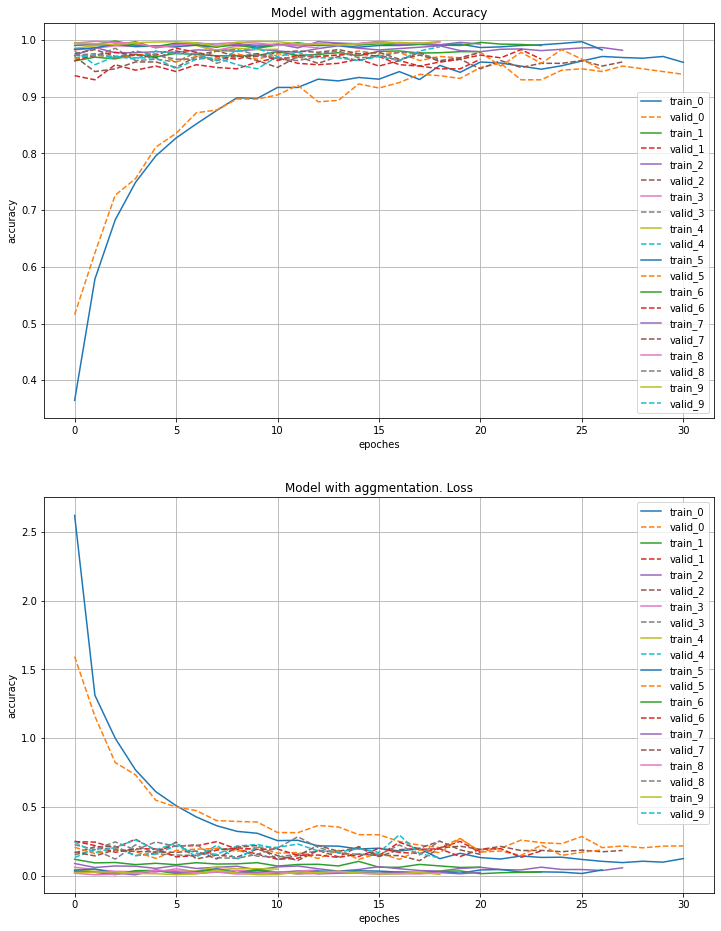

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(2, 1, 1)
for i in range(n):
    plt.plot(result11[i]['train_accuracy'], '-', label=f'train_{i}')
    plt.plot(result11[i]['valid_accuracy'], '--', label=f'valid_{i}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model with aggmentation. Accuracy')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
for j in range(10):
    plt.plot(result11[j]['train_loss'], '-', label=f'train_{j}')
    plt.plot(result11[j]['valid_loss'], '--', label=f'valid_{j}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model with aggmentation. Loss')
plt.grid()
plt.legend()

plt.show()

In [ ]:
print(f"Model0 test accuracy: {np.array([res_['valid_accuracy'][-1] for res_ in result10]).mean()}")
print(f"Model0 test loss: {np.array([res_['valid_loss'][-1] for res_ in result10]).mean()}", end='\n\n')

print(f"Model1 test accuracy: {np.array([res_['valid_accuracy'][-1] for res_ in result11]).mean()}")
print(f"Model1 test loss: {np.array([res_['valid_loss'][-1] for res_ in result11]).mean()}")

Model0 test accuracy: 0.9506053268909455
Model0 test loss: 0.41147201359272

Model1 test accuracy: 0.9653752982616425
Model1 test loss: 0.18626221865415574


#### GRID SEARCH

In [ ]:
%%time
result_list1 = []
for loss, optimizer in product(losses, optimizers):
    model_ = Model(inputs=input1, outputs=output1)

    model_.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    hh_ = model_.fit(datagen.flow(X_train, y_train, batch_size=64),
                     validation_data=datagen.flow(X_test, y_test),
                     epochs=n_epoches, workers=10, 
                     callbacks=[callback], verbose=0)
    
    result_list1.append({
        'loss': loss,
        'optimizer': optimizer,
        'train_loss': hh_.history['loss'],
        'valid_loss': hh_.history['val_loss'],
        'train_accuracy': hh_.history['accuracy'],
        'valid_accuracy': hh_.history['val_accuracy']
    })

CPU times: user 10min 10s, sys: 1min 44s, total: 11min 54s
Wall time: 8min 25s


In [ ]:
with open('grid_result1.json', 'w') as f:
    json.dump(result_list1, f, indent=4)

### 2 блока Conv2D+Conv2D+MaxPooling2D

In [ ]:
input2 = Input(shape=X_train.shape[1:])

x40 = Conv2D(64, (3, 3), padding='valid', activation='relu')(input2)
x41 = Conv2D(64, (3, 3), padding='valid', activation='relu')(x40)
x42 = MaxPooling2D(pool_size=(2, 2))(x41)

x43 = Conv2D(128, (3, 3), padding='valid', activation='relu')(x42)
x44 = Conv2D(128, (3, 3), padding='valid', activation='relu')(x43)
x45 = AveragePooling2D(pool_size=(2, 2))(x44)
x46 = Dropout(0.1)(x45)

x47 = Flatten()(x46)
x48 = Dense(512, activation='relu')(x47)
x49 = Dense(512, activation='relu')(x48)
x50 = Dropout(0.5)(x49)

output2 = Dense(y_train.shape[1], activation='softmax')(x50)

In [ ]:
%%time
result20 = []
for _ in range(n):
    model20 = Model(inputs=input2, outputs=output2)

    model20.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    
    hh20 = model20.fit(X_train,
                      y_train,
                      epochs=n_epoches,
                      batch_size=64, 
                      validation_data=(X_test, y_test),
                      callbacks=[callback],
                      verbose=0)
    
    result20.append({
        'train_loss': hh20.history['loss'],
        'valid_loss': hh20.history['val_loss'],
        'train_accuracy': hh20.history['accuracy'],
        'valid_accuracy': hh20.history['val_accuracy']
    })

CPU times: user 1min 56s, sys: 17.4 s, total: 2min 13s
Wall time: 8min 55s


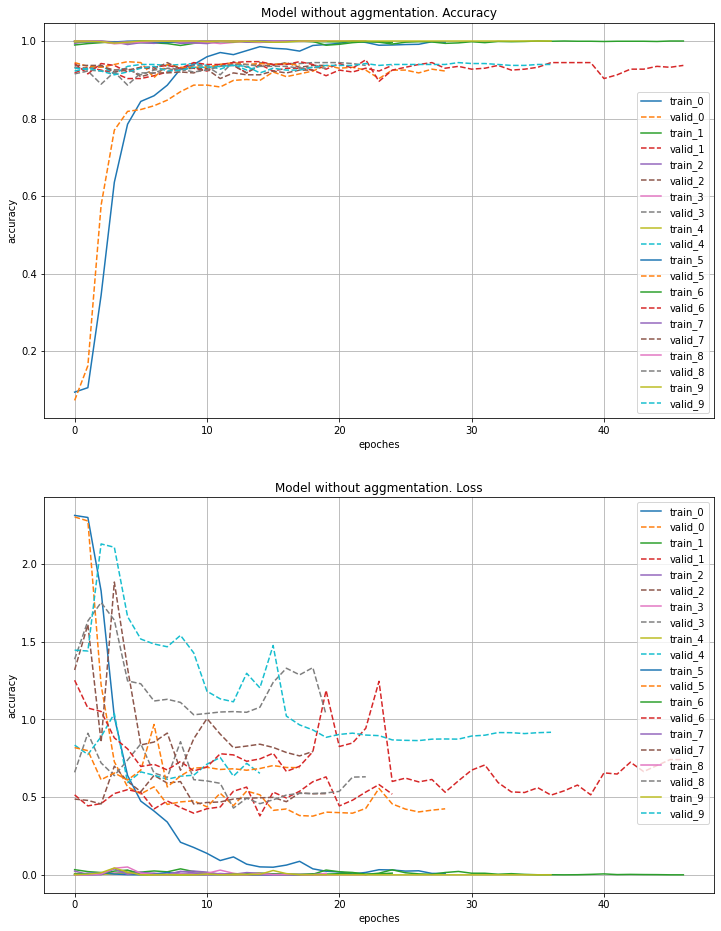

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(2, 1, 1)
for i in range(n):
    plt.plot(result20[i]['train_accuracy'], '-', label=f'train_{i}')
    plt.plot(result20[i]['valid_accuracy'], '--', label=f'valid_{i}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model without aggmentation. Accuracy')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
for j in range(10):
    plt.plot(result20[j]['train_loss'], '-', label=f'train_{j}')
    plt.plot(result20[j]['valid_loss'], '--', label=f'valid_{j}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model without aggmentation. Loss')
plt.grid()
plt.legend()

plt.show()

In [ ]:
model20.summary()

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 26, 26, 128)       147584    
_________________________________________________________________
average_pooling2d_7 (Average (None, 13, 13, 128)       0  

In [ ]:
%%time
result21 = []
for _ in range(n):
    model21 = Model(inputs=input2, outputs=output2)

    model21.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    
    hh21 = model21.fit(datagen.flow(X_train, y_train, batch_size=64),
                     validation_data=datagen.flow(X_test, y_test),
                     epochs=n_epoches, workers=10, 
                     callbacks=[callback], verbose=0)
    
    result21.append({
        'train_loss': hh21.history['loss'],
        'valid_loss': hh21.history['val_loss'],
        'train_accuracy': hh21.history['accuracy'],
        'valid_accuracy': hh21.history['val_accuracy']
    })

CPU times: user 13min 51s, sys: 1min 58s, total: 15min 50s
Wall time: 13min 57s


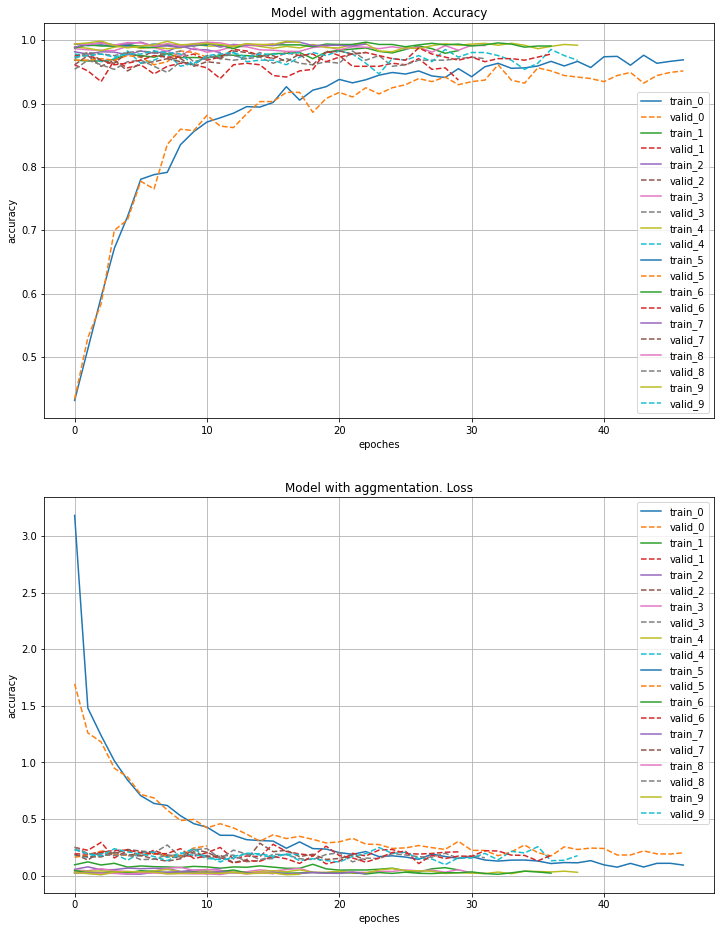

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(2, 1, 1)
for i in range(n):
    plt.plot(result21[i]['train_accuracy'], '-', label=f'train_{i}')
    plt.plot(result21[i]['valid_accuracy'], '--', label=f'valid_{i}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model with aggmentation. Accuracy')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
for j in range(10):
    plt.plot(result21[j]['train_loss'], '-', label=f'train_{j}')
    plt.plot(result21[j]['valid_loss'], '--', label=f'valid_{j}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model with aggmentation. Loss')
plt.grid()
plt.legend()

plt.show()

In [ ]:
print(f"Model0 test accuracy: {np.array([res_['valid_accuracy'][-1] for res_ in result20]).mean()}")
print(f"Model0 test loss: {np.array([res_['valid_loss'][-1] for res_ in result20]).mean()}", end='\n\n')

print(f"Model1 test accuracy: {np.array([res_['valid_accuracy'][-1] for res_ in result21]).mean()}")
print(f"Model1 test loss: {np.array([res_['valid_loss'][-1] for res_ in result21]).mean()}")

Model0 test accuracy: 0.9336561620235443
Model0 test loss: 0.6925033241510391

Model1 test accuracy: 0.9675544798374176
Model1 test loss: 0.18103422820568085


#### GRID SEARCH

In [ ]:
%%time
result_list2 = []
for loss, optimizer in product(losses, optimizers):
    model_ = Model(inputs=input2, outputs=output2)

    model_.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    hh_ = model_.fit(datagen.flow(X_train, y_train, batch_size=64),
                     validation_data=datagen.flow(X_test, y_test),
                     epochs=n_epoches, workers=10, 
                     callbacks=[callback], verbose=0)
    
    result_list2.append({
        'loss': loss,
        'optimizer': optimizer,
        'train_loss': hh_.history['loss'],
        'valid_loss': hh_.history['val_loss'],
        'train_accuracy': hh_.history['accuracy'],
        'valid_accuracy': hh_.history['val_accuracy']
    })

CPU times: user 16min 22s, sys: 2min 32s, total: 18min 54s
Wall time: 16min 17s


In [ ]:
with open('grid_result2.json', 'w') as f:
    json.dump(result_list2, f, indent=4)

### 2 блока Conv2D+Conv2D+AveragePooling2D

In [ ]:
input3 = Input(shape=X_train.shape[1:])

x40 = Conv2D(64, (3, 3), padding='valid', activation='relu')(input3)
x41 = Conv2D(64, (3, 3), padding='valid', activation='relu')(x40)
x42 = AveragePooling2D(pool_size=(2, 2))(x41)

x43 = Conv2D(128, (3, 3), padding='valid', activation='relu')(x42)
x44 = Conv2D(128, (3, 3), padding='valid', activation='relu')(x43)
x45 = AveragePooling2D(pool_size=(2, 2))(x44)
x46 = Dropout(0.1)(x45)

x47 = Flatten()(x46)
x48 = Dense(512, activation='relu')(x47)
x49 = Dense(512, activation='relu')(x48)
x50 = Dropout(0.5)(x49)

output3 = Dense(y_train.shape[1], activation='softmax')(x50)

In [ ]:
%%time
result30 = []
for _ in range(n):
    model30 = Model(inputs=input3, outputs=output3)

    model30.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    
    hh30 = model30.fit(X_train,
                      y_train,
                      epochs=n_epoches,
                      batch_size=64, 
                      validation_data=(X_test, y_test),
                      callbacks=[callback],
                      verbose=0)
    
    result30.append({
        'train_loss': hh30.history['loss'],
        'valid_loss': hh30.history['val_loss'],
        'train_accuracy': hh30.history['accuracy'],
        'valid_accuracy': hh30.history['val_accuracy']
    })

CPU times: user 1min 32s, sys: 14 s, total: 1min 47s
Wall time: 6min 27s


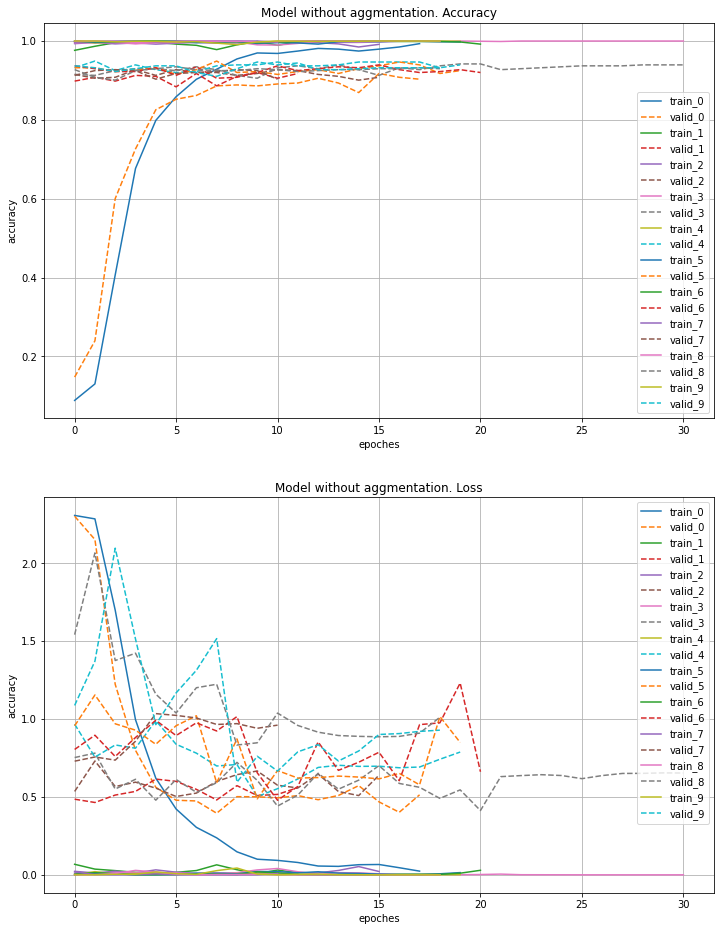

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(2, 1, 1)
for i in range(n):
    plt.plot(result30[i]['train_accuracy'], '-', label=f'train_{i}')
    plt.plot(result30[i]['valid_accuracy'], '--', label=f'valid_{i}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model without aggmentation. Accuracy')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
for j in range(10):
    plt.plot(result30[j]['train_loss'], '-', label=f'train_{j}')
    plt.plot(result30[j]['valid_loss'], '--', label=f'valid_{j}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model without aggmentation. Loss')
plt.grid()
plt.legend()

plt.show()

In [ ]:
model30.summary()

Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
average_pooling2d_8 (Average (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 26, 26, 128)       147584    
_________________________________________________________________
average_pooling2d_9 (Average (None, 13, 13, 128)       0  

In [ ]:
%%time
result31 = []
for _ in range(n):
    model31 = Model(inputs=input3, outputs=output3)

    model31.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    
    hh31 = model31.fit(datagen.flow(X_train, y_train, batch_size=64),
                     validation_data=datagen.flow(X_test, y_test),
                     epochs=n_epoches, workers=10, 
                     callbacks=[callback], verbose=0)
    
    result31.append({
        'train_loss': hh31.history['loss'],
        'valid_loss': hh31.history['val_loss'],
        'train_accuracy': hh31.history['accuracy'],
        'valid_accuracy': hh31.history['val_accuracy']
    })

CPU times: user 10min 49s, sys: 1min 35s, total: 12min 25s
Wall time: 10min 41s


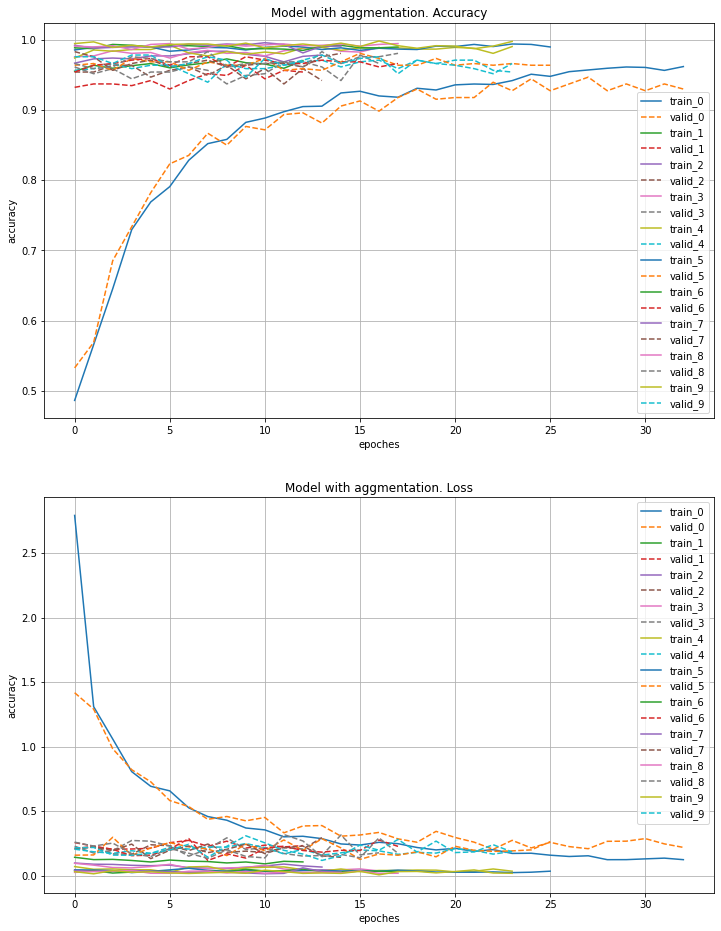

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(2, 1, 1)
for i in range(n):
    plt.plot(result31[i]['train_accuracy'], '-', label=f'train_{i}')
    plt.plot(result31[i]['valid_accuracy'], '--', label=f'valid_{i}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model with aggmentation. Accuracy')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
for j in range(10):
    plt.plot(result31[j]['train_loss'], '-', label=f'train_{j}')
    plt.plot(result31[j]['valid_loss'], '--', label=f'valid_{j}')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.title('Model with aggmentation. Loss')
plt.grid()
plt.legend()

plt.show()

In [ ]:
print(f"Model0 test accuracy: {np.array([res_['valid_accuracy'][-1] for res_ in result30]).mean()}")
print(f"Model0 test loss: {np.array([res_['valid_loss'][-1] for res_ in result30]).mean()}", end='\n\n')

print(f"Model1 test accuracy: {np.array([res_['valid_accuracy'][-1] for res_ in result31]).mean()}")
print(f"Model1 test loss: {np.array([res_['valid_loss'][-1] for res_ in result31]).mean()}")

Model0 test accuracy: 0.9217917740345001
Model0 test loss: 0.7570271372795105

Model1 test accuracy: 0.9602905690670014
Model1 test loss: 0.20964485108852388


#### GRID SEARCH

In [ ]:
%%time
result_list3 = []
for loss, optimizer in product(losses, optimizers):
    model_ = Model(inputs=input3, outputs=output3)

    model_.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    hh_ = model_.fit(datagen.flow(X_train, y_train, batch_size=64),
                     validation_data=datagen.flow(X_test, y_test),
                     epochs=n_epoches, workers=10, 
                     callbacks=[callback], verbose=0)
    
    result_list3.append({
        'loss': loss,
        'optimizer': optimizer,
        'train_loss': hh_.history['loss'],
        'valid_loss': hh_.history['val_loss'],
        'train_accuracy': hh_.history['accuracy'],
        'valid_accuracy': hh_.history['val_accuracy']
    })

CPU times: user 14min 54s, sys: 2min 25s, total: 17min 19s
Wall time: 14min 48s


In [ ]:
with open('grid_result3.json', 'w') as f:
    json.dump(result_list3, f, indent=4)

### Представлю все данные в виде датафрейма

In [ ]:
grid_result = []

for i in range(4):
    with open(f'grid_result{i}.json') as f:
        result_ = json.load(f)
        grid_result.append(result_)

In [ ]:
for i in range(len(grid_result)):
    res_ = []
    for j in range(len(grid_result[i])):
        res_.append({
            'loss': grid_result[i][j]['loss'],
            'optimizer': grid_result[i][j]['optimizer'],
            'train_accuracy': np.array(grid_result[i][j]['train_accuracy']).mean(),
            'train_loss': np.array(grid_result[i][j]['train_loss']).mean(),
            'valid_accuracy': np.array(grid_result[i][j]['valid_accuracy']).mean(),
            'valid_loss': np.array(grid_result[i][j]['valid_loss']).mean()
        })
    grid_result[i] = res_

In [ ]:
df = pd.DataFrame(columns=['loss', 'optimizer', 'train_accuracy', 'train_loss', 'valid_accuracy', 'valid_loss'])
df

,loss,optimizer,train_accuracy,train_loss,valid_accuracy,valid_loss


In [ ]:
for i in range(len(grid_result)):
    df_ = pd.DataFrame(grid_result[i])
    df_['model_number'] = i
    df = pd.concat([df, df_], ignore_index=True)

In [ ]:
df.head()

,loss,optimizer,train_accuracy,train_loss,valid_accuracy,valid_loss,model_number
0,categorical_crossentropy,Adam,0.991627,0.026699,0.978394,0.225740,0.0
1,categorical_crossentropy,Nadam,0.993864,0.021804,0.980487,0.241914,0.0
2,categorical_crossentropy,RMSprop,0.994629,0.017894,0.982013,0.259979,0.0
3,categorical_crossentropy,Adagrad,0.997776,0.007664,0.984867,0.271540,0.0
4,categorical_crossentropy,Adadelta,0.997938,0.007236,0.984504,0.300762,0.0


In [ ]:
df.iloc[np.argmax(df.valid_accuracy)]

loss              categorical_crossentropy
optimizer                           Adamax
train_accuracy                    0.998414
train_loss                      0.00616386
valid_accuracy                    0.985193
valid_loss                        0.305001
model_number                             0
Name: 5, dtype: object

## Обучаю финальную модель

In [ ]:
final_model = Model(inputs=input0, outputs=output0)

final_model.compile(loss='categorical_crossentropy',
              optimizer='Adamax',
              metrics=['accuracy'])


hh = final_model.fit(datagen.flow(X_train, y_train, batch_size=64),
                     validation_data=datagen.flow(X_test, y_test),
                     epochs=n_epoches, workers=10, 
                     callbacks=[callback])

Epoch 1/500
26/26 [==============================] - 36s 124ms/step - loss: 2.3205 - accuracy: 0.1007 - val_loss: 2.3029 - val_accuracy: 0.0896
Epoch 2/500
26/26 [==============================] - 2s 80ms/step - loss: 2.3029 - accuracy: 0.0910 - val_loss: 2.3035 - val_accuracy: 0.1162
Epoch 3/500
26/26 [==============================] - 3s 87ms/step - loss: 2.3029 - accuracy: 0.1049 - val_loss: 2.3044 - val_accuracy: 0.0920
Epoch 4/500
26/26 [==============================] - 3s 82ms/step - loss: 2.3020 - accuracy: 0.1037 - val_loss: 2.3007 - val_accuracy: 0.2397
Epoch 5/500
26/26 [==============================] - 3s 85ms/step - loss: 2.2937 - accuracy: 0.1704 - val_loss: 2.2803 - val_accuracy: 0.1864
Epoch 6/500
26/26 [==============================] - 3s 79ms/step - loss: 2.2201 - accuracy: 0.2068 - val_loss: 2.1275 - val_accuracy: 0.2300
Epoch 7/500
26/26 [==============================] - 3s 82ms/step - loss: 1.9720 - accuracy: 0.2941 - val_loss: 1.8140 - val_accuracy: 0.3971
Epoc

In [ ]:
test_preds = final_model.predict(X_test)

In [ ]:
y_test_cat = np.array([np.where(value)[0][0] for value in y_test])
y_test_cat[:10]

array([5, 5, 8, 4, 5, 5, 3, 4, 6, 2])

In [ ]:
test_preds_cat = np.array([np.argmax(value) for value in test_preds])
test_preds_cat[:10]

array([5, 5, 8, 4, 5, 5, 3, 4, 3, 2])

In [ ]:
print(classification_report(y_test_cat, test_preds_cat))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        44
           1       0.97      1.00      0.99        36
           2       0.96      0.96      0.96        45
           3       0.95      1.00      0.98        40
           4       1.00      1.00      1.00        50
           5       0.97      0.93      0.95        41
           6       1.00      0.93      0.96        40
           7       0.97      0.97      0.97        37
           8       0.95      0.97      0.96        38
           9       1.00      1.00      1.00        42

    accuracy                           0.98       413
   macro avg       0.98      0.98      0.98       413
weighted avg       0.98      0.98      0.98       413



## Визуализирую результат

In [ ]:
n_samples = np.random.choice(np.arange(len(X_test)), size=9)
n_samples

array([153, 287,  56, 246, 152,  46, 126, 234, 252])

In [ ]:
preds = final_model.predict(X_test[n_samples])

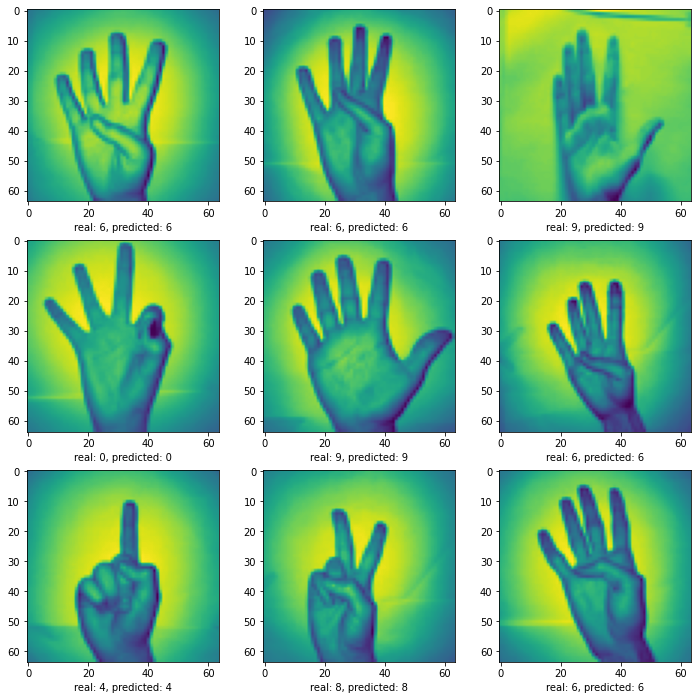

In [ ]:
plt.figure(figsize=(12, 12))

for i in range(len(n_samples)):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[n_samples[i],:,:,0])
    plt.xlabel(f'real: {np.where(y_test[n_samples[i]])[0][0]}, predicted: {np.argmax(preds[i])}')

plt.show()